### 20190316 agenda

* modern portfolio theory (MPT)
* linear regression: capital asset pricing model (CAPM)
* autoregressive moving-average model (ARMA)

#### modern portfolio theory (MPT)
* MPT by Markowitz (1952)
    * a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk
    * aka mean-variance analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# np.random.seed(123)
n_assets = 5
n_obs = 300

In [2]:
# assume that the returns follow Brownian motion

def return_generator(N = 100, r = 0.0, sigma = 0.2):
    return np.random.randn(1, N) * sigma + r

In [3]:
ret_vec = np.zeros([n_assets, n_obs])

r_vector = np.random.randint(0, 50, [1, n_assets]) 
print(r_vector)
s_vector = np.random.randint(30, 60, [1, n_assets])
print(s_vector)
for i in range(n_assets):
    ret_vec[i, :] = return_generator(n_obs, r_vector[0, i] / 100 / n_obs, s_vector[0, i] / 100 / np.sqrt(n_obs))
    
print(ret_vec)

[[45 25  4 41  9]]
[[38 41 45 36 32]]
[[-0.01479711  0.00426209 -0.01150459 ...  0.00830141 -0.015348
  -0.01907687]
 [-0.00241667  0.00464614 -0.00556609 ... -0.01122346 -0.00387622
  -0.02374327]
 [ 0.01469519  0.0239454  -0.04323734 ... -0.02306484  0.01532651
   0.01648358]
 [ 0.02639783 -0.03187014  0.00191437 ... -0.01197962 -0.02149345
   0.00652247]
 [ 0.02684086 -0.00476821 -0.00509284 ... -0.0140991   0.00731275
  -0.00766687]]


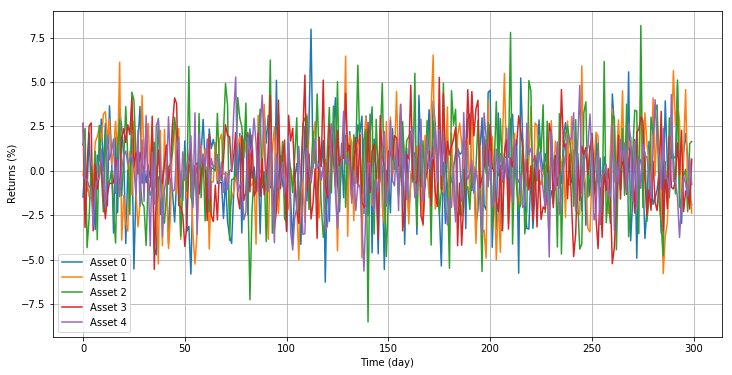

In [4]:
plt.figure(figsize = (12, 6))
plt.plot(ret_vec.T * 100);
plt.xlabel('Time (day)')
plt.ylabel('Returns (%)')
plt.grid()
asset_names = ["Asset {}".format(str(item)) for item in range(n_assets)]
plt.legend(asset_names)

In [5]:
# try a random weight vector
w = np.random.random(n_assets)
w = w / np.sum(w) # normalization
print(w)

[0.20547389 0.1155181  0.1045889  0.37214465 0.20227445]


In [6]:
p = np.asmatrix(np.mean(ret_vec, axis = 1))
w = np.asmatrix(w)
C = np.asmatrix(np.cov(ret_vec))

mu = w * p.T
sigma = np.sqrt(w * C * w.T)

print(mu)
print(sigma)

[[0.00021764]]
[[0.01114115]]


In [7]:
# put it together

def generate_one_portfolio(ret_vec):
    
    w = np.random.random(ret_vec.shape[0])
    w = w / np.sum(w)
    
    p = np.asmatrix(np.mean(ret_vec, axis = 1))
    w = np.asmatrix(w)
    C = np.asmatrix(np.cov(ret_vec))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

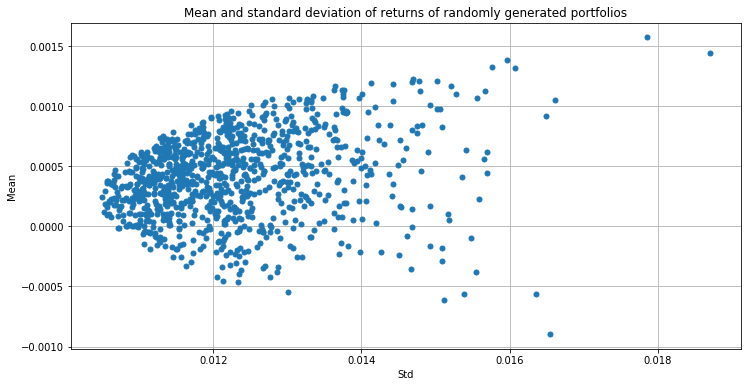

In [8]:
n_portfolios = 1000

means, stds = np.column_stack([generate_one_portfolio(ret_vec) for _ in np.arange(n_portfolios)])

plt.figure(figsize = (12, 6))
plt.plot(stds, means, 'o', markersize = 5)
plt.xlabel('Std')
plt.ylabel('Mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.grid()

In [9]:
import cvxopt as opt
from cvxopt import blas, solvers

def opt_portfolio(ret_vector):
    
    solvers.options['show_progress'] = False
    
    returns = np.asmatrix(ret_vector)
    
    N = 100
    risk_aversion_levels = [10 ** (4 * t / N - 2) for t in range(N)]
    
    S = opt.matrix(np.cov(ret_vector))
    p = opt.matrix(np.mean(ret_vector, axis = 1))
    
    n = ret_vector.shape[0]
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    portfolios = [solvers.qp(level * S, -p, G, h, A, b)['x'] for level in risk_aversion_levels]
    
    returns = [blas.dot(p, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    
    m = np.polyfit(returns, risks, 2)
    level = np.sqrt(m[2] / m[0])
    
    wt = solvers.qp(opt.matrix(level * S), -p, G, h, A, b)['x']
    
    return wt, returns, risks

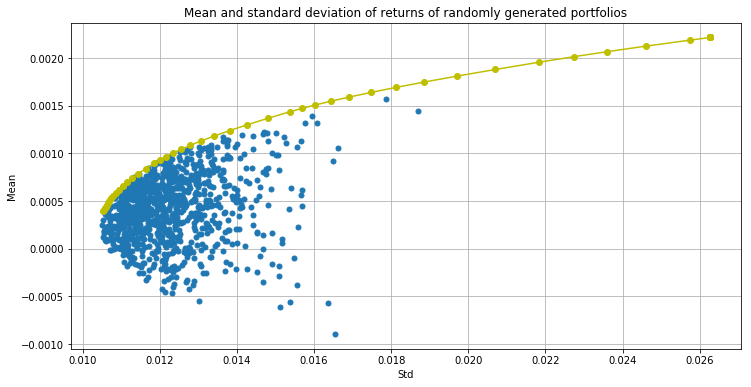

In [10]:
weights, returns, risks = opt_portfolio(ret_vec)

plt.figure(figsize = (12, 6))
plt.plot(stds, means, 'o', markersize = 5)
plt.xlabel('Std')
plt.ylabel('Mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.grid()

plt.plot(risks, returns, 'y-o')

[ 1.14e-07]
[ 2.80e-08]
[ 1.00e+00]
[ 1.12e-07]
[ 1.46e-07]



Text(0.5,1,'Ingredient of portfolio')

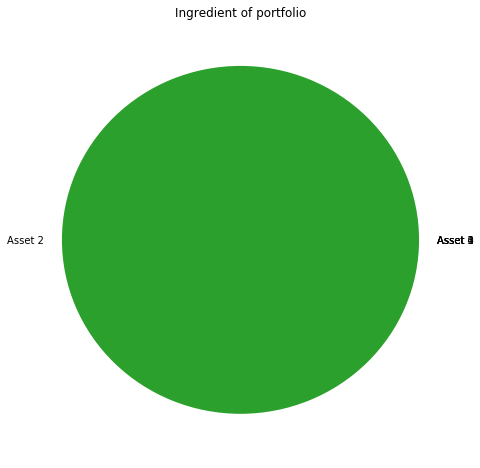

In [11]:
print(weights)

plt.figure(figsize = (8, 8))
plt.pie(weights, labels = asset_names)
plt.title("Ingredient of portfolio")

In [12]:
opt_portfolio_ret_vector = np.asmatrix(ret_vec.T).dot(np.asmatrix(weights))
opt_porfolio_ret = np.cumprod(opt_portfolio_ret_vector / 100 + 1) - 1

[0.19646954 0.26431814 0.17770357 0.13333    0.22817874]


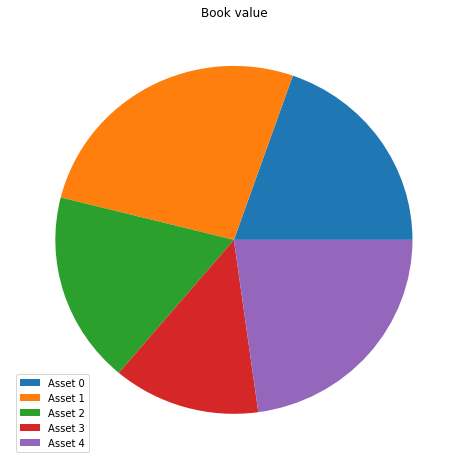

In [13]:
book_value_weights = np.random.random(n_assets)
book_value_weights = book_value_weights / np.sum(book_value_weights)
print(book_value_weights)

plt.figure(figsize = (8, 8))
plt.pie(book_value_weights)
plt.grid()
plt.title("Book value")
plt.legend(asset_names)

benchmark_portfolio_ret_vector = book_value_weights.dot(ret_vec)
benchmark_portfolio_ret = np.cumprod(benchmark_portfolio_ret_vector / 100 + 1) - 1

Text(0.5,1,'Benchmark')

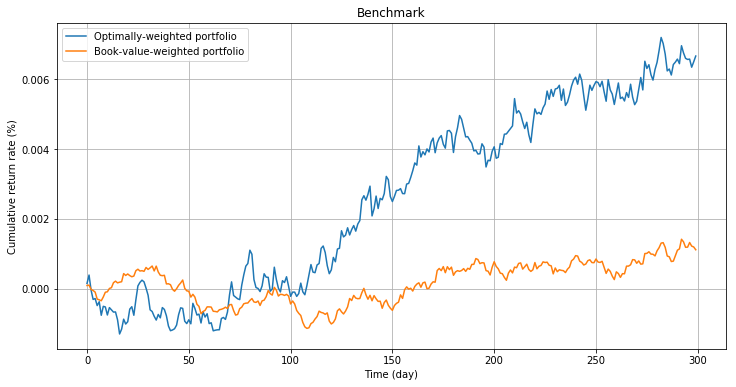

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(opt_porfolio_ret.T)
plt.plot(benchmark_portfolio_ret.T)
plt.legend(["Optimally-weighted portfolio", "Book-value-weighted portfolio"])
plt.ylabel("Cumulative return rate (%)")
plt.xlabel("Time (day)")
plt.grid()
plt.title("Benchmark")

#### benchmark portfolio performance
* [Shapre ratio](https://en.wikipedia.org/wiki/Sharpe_ratio)

In [15]:
sharpe = np.mean(opt_portfolio_ret_vector - benchmark_portfolio_ret_vector) / np.std(opt_portfolio_ret_vector - benchmark_portfolio_ret_vector)
print(sharpe)

0.06481611684528271


#### linear regression: capital asset pricing model (CAPM)
* By William Sharpe, Jack Treynor, Jan Mossin, and John Lintner; also see [wiki](https://en.wikipedia.org/wiki/Capital_asset_pricing_model).
    ![](https://cdn-images-1.medium.com/max/800/1*jh7T0OZTOjXKciaUALG3gA.png)
* See [statsmodels](http://www.statsmodels.org/stable/) for statistical models.

In [16]:
import statsmodels.api as sm

idx = np.argmax(weights)
m = sm.add_constant(benchmark_portfolio_ret_vector.T)
model = sm.OLS(opt_portfolio_ret_vector, m)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     97.70
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           4.11e-20
Time:                        18:01:34   Log-Likelihood:                 709.10
No. Observations:                 300   AIC:                            -1414.
Df Residuals:                     298   BIC:                            -1407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.351      0.1

#### ARMA model
* See [Building ARMA models: Examples](http://www.phdeconomics.sssup.it/documents/Lesson15.pdf).

In [17]:
df = pd.read_csv("cpi.csv")
df.set_index(df.Date)
df.tail(10)

Date    Index  Inflation
1203  2013-04-01  232.531      -0.10
1204  2013-05-01  232.945       0.18
1205  2013-06-01  233.504       0.24
1206  2013-07-01  233.596       0.04
1207  2013-08-01  233.877       0.12
1208  2013-09-01  234.149       0.12
1209  2013-10-01  233.546      -0.26
1210  2013-11-01  233.069      -0.20
1211  2013-12-01  233.049      -0.01
1212  2014-01-01  233.916       0.37

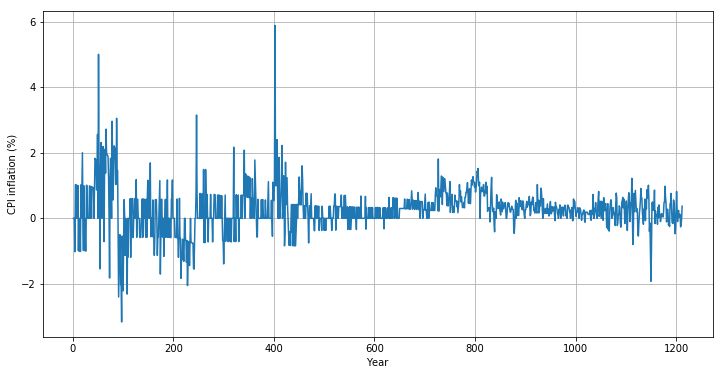

In [18]:
plt.figure(figsize = (12, 6))
plt.plot(df["Inflation"])
plt.xlabel("Year")
plt.ylabel("CPI inflation (%)")
plt.grid()

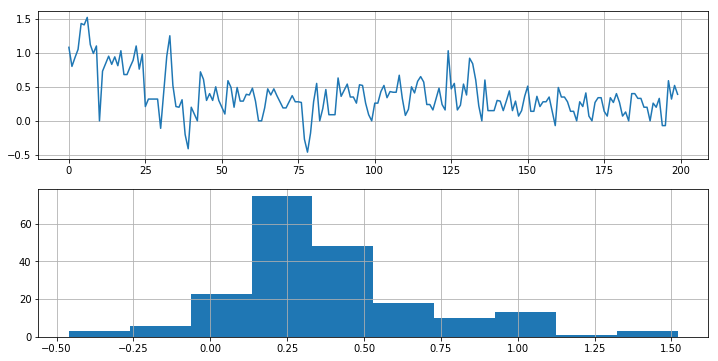

In [19]:
x = np.array(df.Inflation[800 : 1000])

plt.figure(figsize = (12, 6))
plt.subplot(211)
plt.plot(x)
plt.grid()
plt.subplot(212)
plt.hist(x)
plt.grid()

##### unit root test
* See [augmented Dickey-Fuller unit root test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
* See [單根與隨機趨勢](http://homepage.ntu.edu.tw/~sschen/Book/Slides/Ch6Unitroot.pdf) by 陳旭昇.

In [20]:
sm.tsa.stattools.adfuller(x)

(-3.3351429065056752,
 0.013378829418456832,
 14,
 185,
 {'1%': -3.4662005731940853,
  '5%': -2.8772932777920364,
  '10%': -2.575167750182615},
 -31.360587639865855)

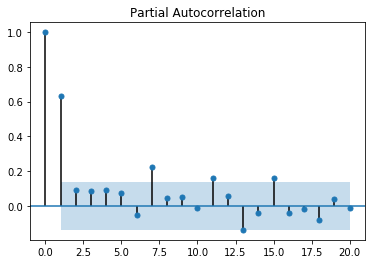

<Figure size 864x432 with 0 Axes>

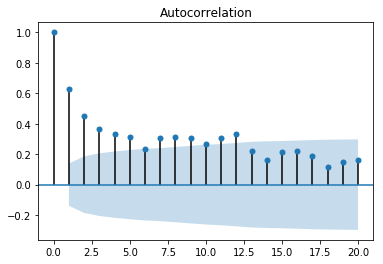

<Figure size 864x432 with 0 Axes>

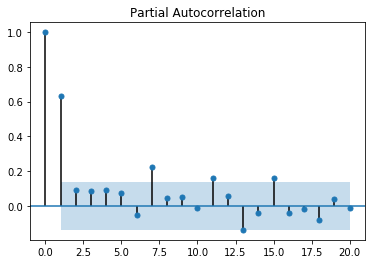

In [21]:
plt.figure(figsize = (12, 6))
sm.graphics.tsa.plot_acf(x, lags = 20)
plt.figure(figsize = (12, 6))
sm.graphics.tsa.plot_pacf(x, lags = 20)

In [22]:
model = sm.tsa.ARMA(x, (1, 0)).fit(disp = False)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  200
Model:                     ARMA(1, 0)   Log Likelihood                  -3.712
Method:                       css-mle   S.D. of innovations              0.246
Date:                Wed, 20 Mar 2019   AIC                             13.424
Time:                        18:01:36   BIC                             23.319
Sample:                             0   HQIC                            17.428
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3827      0.048      7.942      0.000       0.288       0.477
ar.L1.y        0.6417      0.055     11.702      0.000       0.534       0.749
                                    Roots           

<Figure size 864x432 with 0 Axes>

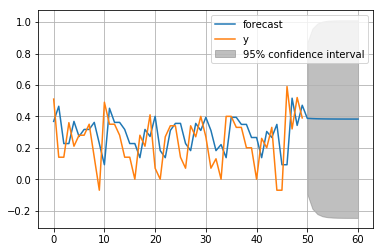

In [23]:
plt.figure(figsize = (12, 6))
model.plot_predict(x.shape[0] - 50, x.shape[0] + 10)
plt.grid()